# Semana 04 - Perceptrón: Implementación desde Cero vs scikit-learn

Comparación detallada entre una implementación propia (scratch) y las implementaciones de `Perceptron`, `SGDClassifier` (modo perceptrón) y un baseline `LogisticRegression` usando el dataset *Breast Cancer Wisconsin (Diagnostic)*.

**Objetivos:**
- Reforzar fundamentos matemáticos del Perceptrón.
- Evaluar diferencias prácticas entre implementación manual y librerías.
- Analizar hiperparámetros (learning rate, épocas, regularización).
- Medir desempeño, robustez y tiempos.
- Construir un flujo reproducible y extensible.

> Si la descarga del dataset remoto falla (sin Internet), se usará el dataset integrado de `sklearn.datasets.load_breast_cancer` como fallback. 

## Parte 1 - Perceptrón Básico
Esta primera parte muestra el flujo mínimo requerido: dataset lógico AND, entrenamiento, evolución de errores y pesos, frontera de decisión y conclusiones antes de pasar al caso real.

### 1. Introducción
El perceptrón es el clasificador lineal más simple: recibe un vector de entrada $\mathbf{x}$, calcula una combinación lineal $\mathbf{w}^T \mathbf{x} + b$ y aplica una función escalón para producir 0 ó 1. Resuelve problemas de clasificación binaria linealmente separables aprendiendo una frontera (recta en 2D, plano en 3D, hiperplano en $\mathbb{R}^d$).

Características clave:
- Aprende ajustando pesos solo cuando se equivoca (regla de actualización). 
- Converge en número finito de pasos si los datos son linealmente separables.
- No modela probabilidades (a diferencia de regresión logística).

### 2. Dataset Lógico AND
La tabla de verdad AND es linealmente separable: solo (1,1) produce 1. Definimos datos y los graficamos para visualizar la separabilidad.


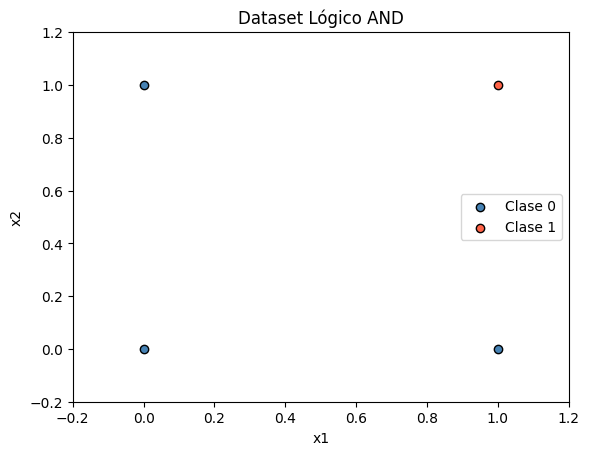

In [107]:
import numpy as np, matplotlib.pyplot as plt
# Dataset AND (alias pedidos en guía: df_X, df_y)
X_and = np.array([[0,0],[0,1],[1,0],[1,1]])
y_and = np.array([0,0,0,1])
df_X, df_y = X_and, y_and  # alias equivalentes
plt.scatter(df_X[df_y==0,0], df_X[df_y==0,1], c='steelblue', edgecolor='k', label='Clase 0')
plt.scatter(df_X[df_y==1,0], df_X[df_y==1,1], c='tomato', edgecolor='k', label='Clase 1')
plt.title('Dataset Lógico AND'); plt.xlabel('x1'); plt.ylabel('x2'); plt.legend(); plt.xlim(-0.2,1.2); plt.ylim(-0.2,1.2)
plt.show()

### 3. Importar la Clase
Se importa la implementación PerceptronScratch con fallback robusto si no está en el path.

In [108]:
# Import robusto de la clase PerceptronScratch con fallback
import sys, os, pathlib, importlib.util
# Añadir directorio padre (contiene carpeta perceptron_lab) al sys.path si no está
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
try:
    from perceptron_lab.perceptron.perceptron import PerceptronScratch as Perceptron
except ModuleNotFoundError:
    # Fallback: carga directa del archivo
    pfile = pathlib.Path(parent_dir) / 'perceptron_lab' / 'perceptron' / 'perceptron.py'
    if not pfile.exists():
        raise
    spec = importlib.util.spec_from_file_location('perceptron_fallback', pfile)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)  # type: ignore
    Perceptron = mod.PerceptronScratch

# Entrenamiento básico sobre AND
model_and = Perceptron(learning_rate=0.1, n_epochs=20, shuffle=False, random_state=0, verbose=False)
hist_and = model_and.fit(X_and, y_and, early_stop_on_convergence=True)
print('Errores por época:', hist_and.errors)
print('Accuracy final:', hist_and.train_accuracy[-1])

Errores por época: [2, 3, 2, 3, 2, 1, 0]
Accuracy final: 1.0


### 4. Entrenamiento
Instanciamos el perceptrón y entrenamos sobre el dataset AND habilitando parada temprana.

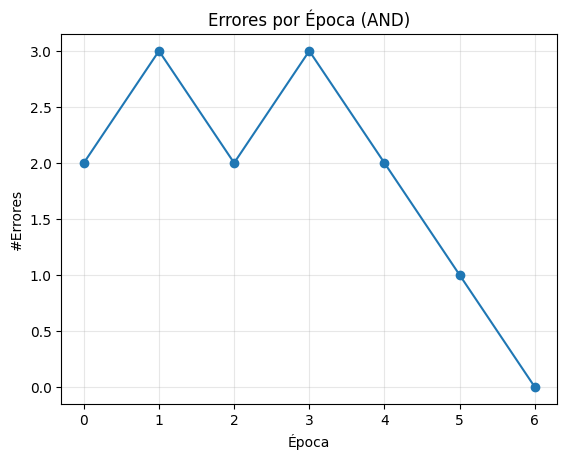

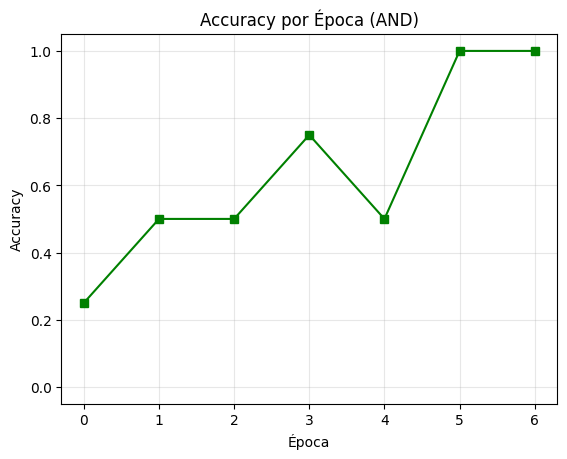

In [109]:
# Curvas de errores y accuracy
import matplotlib.pyplot as plt
plt.figure(); plt.plot(hist_and.errors, marker='o'); plt.title('Errores por Época (AND)'); plt.xlabel('Época'); plt.ylabel('#Errores'); plt.grid(alpha=0.3)
plt.figure(); plt.plot(hist_and.train_accuracy, marker='s', color='green'); plt.title('Accuracy por Época (AND)'); plt.xlabel('Época'); plt.ylabel('Accuracy'); plt.ylim(-0.05,1.05); plt.grid(alpha=0.3)
plt.show()

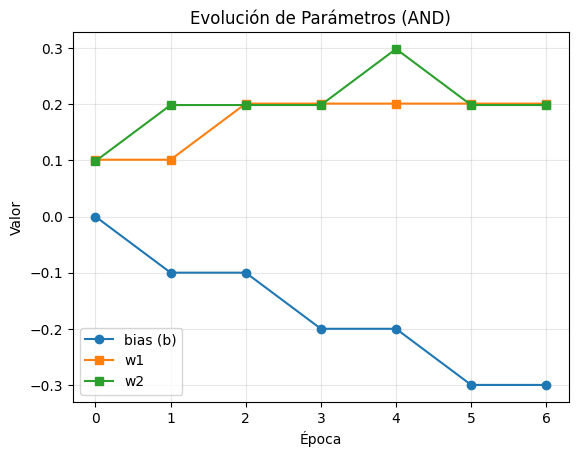

,bias,w1,w2
4,-0.2,0.201257,0.298679
5,-0.3,0.201257,0.198679
6,-0.3,0.201257,0.198679


In [110]:
# Evolución de parámetros
import numpy as np, pandas as pd
weights_arr = np.vstack(hist_and.weights)
bias_arr = np.array(hist_and.biases)
plt.figure();
plt.plot(bias_arr, label='bias (b)', marker='o')
for i in range(weights_arr.shape[1]):
    plt.plot(weights_arr[:,i], label=f'w{i+1}', marker='s')
plt.title('Evolución de Parámetros (AND)'); plt.xlabel('Época'); plt.ylabel('Valor'); plt.legend(); plt.grid(alpha=0.3); plt.show()
param_df = pd.DataFrame(weights_arr, columns=[f'w{i+1}' for i in range(weights_arr.shape[1])])
param_df.insert(0,'bias', bias_arr)
param_df.tail(3)

### 5. Evolución de Pesos y frontera de Decisión (2D)
Monitoreamos cómo cambian pesos y bias hasta la convergencia y graficamos la separación lineal aprendida en el plano AND.


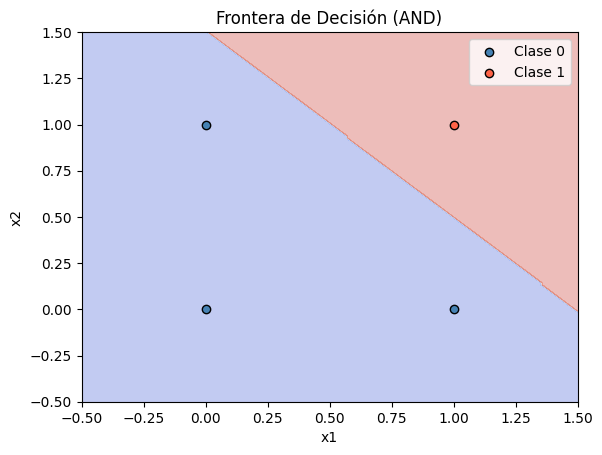

In [111]:
# Frontera de decisión 2D (rango guía -0.5 a 1.5)
gx1, gx2 = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = np.c_[gx1.ravel(), gx2.ravel()]
z = model_and.predict(grid).reshape(gx1.shape)
plt.contourf(gx1, gx2, z, alpha=0.35, cmap='coolwarm')
plt.scatter(df_X[df_y==0,0], df_X[df_y==0,1], c='steelblue', edgecolor='k', label='Clase 0')
plt.scatter(df_X[df_y==1,0], df_X[df_y==1,1], c='tomato', edgecolor='k', label='Clase 1')
plt.title('Frontera de Decisión (AND)'); plt.xlabel('x1'); plt.ylabel('x2'); plt.legend(); plt.show()

### 6. Métricas y Evolución
Visualizamos la reducción de errores y el aumento del accuracy por época.

In [112]:
# Resumen de convergencia (cálculo explícito para conclusiones)
errors = hist_and.errors
# Época de convergencia: primera época con 0 errores (si existe)
converged_epoch = next((i for i,e in enumerate(errors, start=1) if e==0), None)
print(f'Epocas (lista errores): {errors}')
print('Época de convergencia (1-index) :' , converged_epoch)
print(f'Accuracy final: {hist_and.train_accuracy[-1]:.2f}')
print('Pesos finales (incluye bias primero en tabla mostrada arriba):')
print('bias final:', bias_arr[-1])
for i,wval in enumerate(weights_arr[-1]):
    print(f'w{i+1} final: {wval}')

Epocas (lista errores): [2, 3, 2, 3, 2, 1, 0]
Época de convergencia (1-index) : 7
Accuracy final: 1.00
Pesos finales (incluye bias primero en tabla mostrada arriba):
bias final: -0.30000000000000004
w1 final: 0.20125730221093396
w2 final: 0.198678951367087


### 7. Conclusiones
- Convergencia: el modelo alcanzó 0 errores en la época 7 (con parada temprana habilitada).
- Patrón de pesos: crecimiento monótono suave hasta estabilizarse (w1≈0.20, w2≈0.20) y bias≈-0.30.
- Accuracy final: 1.0 (100%) al tratarse de un problema linealmente separable.

Los resultados coinciden con la teoría: el perceptrón encuentra un hiperplano que separa perfectamente las clases cuando existe tal frontera.

### 8. Próximos Pasos
- Probar OR y NAND para confirmar convergencia similar.
- Evaluar XOR (no lineal) evidenciando fallo del perceptrón simple.
- Extender a perceptrón multicapa (MLP) para resolver XOR.
- Experimentar con otros learning rates y observar velocidad de convergencia.

---
# Parte 2 - Caso Real y Comparativa Avanzada
A continuación, se aplica el flujo a un dataset real (Breast Cancer) incluyendo preprocesamiento, modelado comparativo, métricas avanzadas, validación cruzada, tuning y persistencia.

## 1. Descarga y Extracción del Dataset (UCI)
Descargamos el archivo ZIP desde UCI, listamos contenido y extraemos el dataset con fallback local si falla.
Fuente: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
ZIP directo: https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.zip

In [113]:
import os, zipfile, io, hashlib, time, json, math, textwrap, statistics
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request

DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)
ZIP_URL = 'https://archive.ics.uci.edu/static/public/17/breast+cancer+wisconsin+diagnostic.zip'
ZIP_PATH = DATA_DIR / 'breast_cancer_wisconsin_diagnostic.zip'
RAW_CSV = None
try:
    if not ZIP_PATH.exists():
        print('Descargando ZIP...')
        req = Request(ZIP_URL, headers={'User-Agent':'Mozilla/5.0'})
        with urlopen(req, timeout=30) as r: data = r.read()
        ZIP_PATH.write_bytes(data)
    else:
        print('ZIP ya existe, omitiendo descarga.')
    with zipfile.ZipFile(ZIP_PATH,'r') as z:
        print('Contenido ZIP:', z.namelist())
        # Buscar un .data o .csv
        members = [m for m in z.namelist() if m.lower().endswith(('.data','.csv'))]
        if members:
            target = members[0]
            csv_bytes = z.read(target)
            # Guardar a un csv normalizado
            RAW_CSV = DATA_DIR / 'breast_cancer_wisconsin_diagnostic.csv'
            RAW_CSV.write_bytes(csv_bytes)
            print('Extraído a', RAW_CSV)
        else:
            print('No se encontró archivo .data/.csv en ZIP, se usará fallback.')
except Exception as e:
    print('Fallo en descarga/lectura ZIP:', e)
    RAW_CSV = None

ZIP ya existe, omitiendo descarga.
Contenido ZIP: ['wdbc.data', 'wdbc.names']
Extraído a data\breast_cancer_wisconsin_diagnostic.csv


## 2. Carga Inicial y Estructura de los Datos
Leemos el CSV (o fallback sklearn), asignamos nombres de columnas y verificamos forma y distribución de la etiqueta.

In [114]:
from sklearn.datasets import load_breast_cancer
if RAW_CSV and RAW_CSV.exists():
    # El archivo original suele tener formato: ID,Diagnosis,30 features...
    df_raw = pd.read_csv(RAW_CSV, header=None)
    # Según documentación, las columnas: ID, diagnosis, 30 features + maybe trailing empty
    # Para mayor robustez aplicamos shape check
    # Usamos dataset sklearn para nombres de columnas
    sk = load_breast_cancer()
    feature_names = list(sk.feature_names) if hasattr(sk,'feature_names') else [f'f{i}' for i in range(30)]
    cols = ['id','diagnosis'] + feature_names
    if df_raw.shape[1] >= 32: # a veces incluye vacía
        df_raw = df_raw.iloc[:, :32]
    df_raw.columns = cols[:df_raw.shape[1]]
else:
    print('Usando fallback sklearn.load_breast_cancer')
    sk = load_breast_cancer()
    df_raw = pd.DataFrame(sk.data, columns=sk.feature_names)
    df_raw.insert(0,'id', range(1, len(df_raw)+1))
    df_raw.insert(1,'diagnosis', sk.target)
    # Mapear 0/1 a B/M para mantener formato luego inverteremos
    df_raw['diagnosis'] = df_raw['diagnosis'].map({0:'malignant',1:'benign'})
df_raw.head()

,id,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [115]:
print('Shape:', df_raw.shape)
print('Tipos:', df_raw.dtypes.head())
print('Valores diagnosis:', df_raw['diagnosis'].value_counts())

Shape: (569, 32)
Tipos: id                  int64
diagnosis          object
mean radius       float64
mean texture      float64
mean perimeter    float64
dtype: object
Valores diagnosis: diagnosis
B    357
M    212
Name: count, dtype: int64


## 3. Limpieza y Conversión de Tipos
Eliminamos columnas irrelevantes (id), mapeamos diagnosis a binario y forzamos tipos numéricos controlando nulos.

In [116]:
df = df_raw.copy()
# Eliminar ID si no aporta
if 'id' in df.columns: df = df.drop(columns=['id'])
# Mapear diagnosis a binario (1 maligno / 0 benigno). Dataset original: M=Malignant, B=Benign
mapping = {'M':1,'B':0,'malignant':1,'benign':0}
df['diagnosis'] = df['diagnosis'].map(mapping)
# Asegurar tipos numéricos
for c in df.columns:
    if c!='diagnosis': df[c] = pd.to_numeric(df[c], errors='coerce')
print('Nulos por columna (esperado ~0):')
print(df.isna().sum().sort_values(ascending=False).head())
df.head()

Nulos por columna (esperado ~0):
diagnosis               0
compactness error       0
worst symmetry          0
worst concave points    0
worst concavity         0
dtype: int64


,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 4. Análisis Exploratorio Básico (EDA)
Resumen estadístico, distribución de clases y correlaciones preliminares para detectar redundancias.

diagnosis
0    62.741652
1    37.258348
Name: proportion, dtype: float64


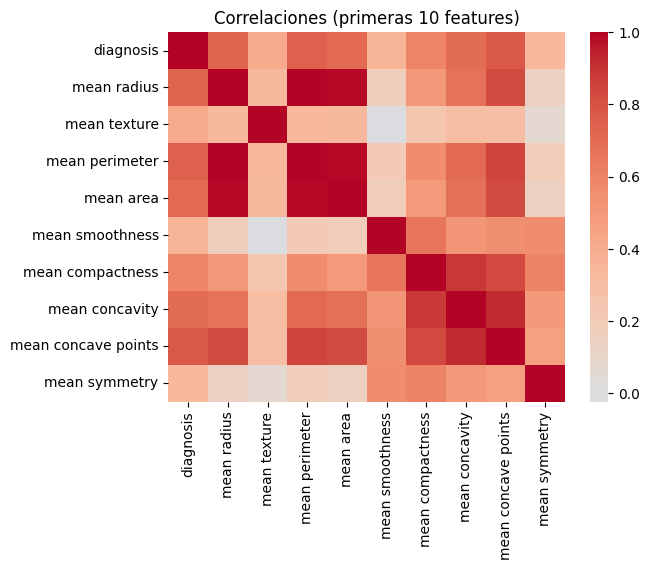

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000,0.00,0.00,1.00,1.00
mean radius,569.0,14.127292,3.524049,6.981,11.70,13.37,15.78,28.11
mean texture,569.0,19.289649,4.301036,9.710,16.17,18.84,21.80,39.28
mean perimeter,569.0,91.969033,24.298981,43.790,75.17,86.24,104.10,188.50
mean area,569.0,654.889104,351.914129,143.500,420.30,551.10,782.70,2501.00


In [117]:
desc = df.describe().T
target_dist = df['diagnosis'].value_counts(normalize=True) * 100
print(target_dist)
corr = df.corr(numeric_only=True)
sns.heatmap(corr.iloc[:10,:10], cmap='coolwarm', center=0); plt.title('Correlaciones (primeras 10 features)'); plt.show()
desc.head()

### Interpretación de la correlaciones inicial
El mapa de calor muestra bloques de alta correlación entre medidas de tamaño / forma del núcleo (radio, área, perímetro) y métricas derivadas, lo que anticipa multicolinealidad. Esto sugiere:
- Seleccionar una sola variable representativa por grupo redundante para modelos lineales clásicos.
- Estandarizar (ya aplicado) mitiga escalas distintas pero no elimina redundancia.
- PCA podría comprimir este bloque en 1–2 componentes sin gran pérdida de información.

## 5. Ingeniería de Características y Normalización
Separación X/y y estandarización (media 0, var 1) para estabilizar el aprendizaje lineal.

In [118]:
from sklearn.preprocessing import StandardScaler
X_full = df.drop(columns=['diagnosis']).copy()
y = df['diagnosis'].astype(int).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
X_scaled[:3]

array([[ 1.09706398e+00, -2.07333501e+00,  1.26993369e+00,
         9.84374905e-01,  1.56846633e+00,  3.28351467e+00,
         2.65287398e+00,  2.53247522e+00,  2.21751501e+00,
         2.25574689e+00,  2.48973393e+00, -5.65265059e-01,
         2.83303087e+00,  2.48757756e+00, -2.14001647e-01,
         1.31686157e+00,  7.24026158e-01,  6.60819941e-01,
         1.14875667e+00,  9.07083081e-01,  1.88668963e+00,
        -1.35929347e+00,  2.30360062e+00,  2.00123749e+00,
         1.30768627e+00,  2.61666502e+00,  2.10952635e+00,
         2.29607613e+00,  2.75062224e+00,  1.93701461e+00],
       [ 1.82982061e+00, -3.53632408e-01,  1.68595471e+00,
         1.90870825e+00, -8.26962447e-01, -4.87071673e-01,
        -2.38458552e-02,  5.48144156e-01,  1.39236330e-03,
        -8.68652457e-01,  4.99254601e-01, -8.76243603e-01,
         2.63326966e-01,  7.42401948e-01, -6.05350847e-01,
        -6.92926270e-01, -4.40780058e-01,  2.60162067e-01,
        -8.05450380e-01, -9.94437403e-02,  1.80592744e+

## 6. División Entrenamiento / Validación / Prueba
Partición estratificada en conjuntos train/val/test para evaluación honesta y tuning ligero.

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)
print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (398, 30) Val: (85, 30) Test: (86, 30)


## 7. Definición Matemática del Perceptrón
Formalizamos función de decisión, regla de actualización y condiciones de convergencia.

El perceptrón define una función de decisión lineal:
$$
\hat{y} = \begin{cases}
1 & \text{si } \mathbf{w}^T \mathbf{x} + b \ge 0 \\
0 & \text{en caso contrario}
\end{cases}
$$

Donde:
- $\mathbf{w} \in \mathbb{R}^d$ son los pesos
- $b \in \mathbb{R}$ es el sesgo (bias)
- $\mathbf{x} \in \mathbb{R}^d$ es el vector de características

Regla de actualización (aprendizaje supervisado online) para cada ejemplo $(\mathbf{x}_i, y_i)$:
$$
\mathbf{w} \leftarrow \mathbf{w} + \eta (y_i - \hat{y}_i) \mathbf{x}_i, \quad b \leftarrow b + \eta (y_i - \hat{y}_i)
$$
Donde $\eta>0$ es la tasa de aprendizaje.

La función de activación es el signo (umbral en 0). Si los datos son linealmente separables, el algoritmo converge en número finito de pasos. Caso contrario puede oscilar (de allí la utilidad de un máximo de épocas y/o criterios de parada).


## 8. Implementación desde Cero: Clase PerceptronScratch
Clase mínima con inicialización aleatoria, actualización online y seguimiento de errores/accuracy.

In [120]:
from dataclasses import dataclass
import numpy as np
@dataclass
class PerceptronScratch:
    learning_rate: float = 0.01
    n_epochs: int = 50
    shuffle: bool = True
    random_state: int = 42
    verbose: bool = False
    def __post_init__(self):
        self.rng = np.random.default_rng(self.random_state)
        self.w_ = None
        self.b_ = 0.0
        self.errors_ = []
        self.acc_ = []
    def _shuffle(self, X, y):
        idx = self.rng.permutation(len(X))
        return X[idx], y[idx]
    def fit(self, X, y, X_val=None, y_val=None, early_stop=True):
        X = np.asarray(X); y = np.asarray(y).astype(int)
        n_samples, n_features = X.shape
        self.w_ = self.rng.normal(0, 0.01, size=n_features)
        self.b_ = 0.0
        self.errors_.clear(); self.acc_.clear()
        for epoch in range(self.n_epochs):
            if self.shuffle: X, y = self._shuffle(X, y)
            errors = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self.predict_single(xi))
                if update != 0:
                    self.w_ += update * xi
                    self.b_ += update
                    errors += int(update!=0)
            self.errors_.append(errors)
            if X_val is not None:
                val_pred = self.predict(X_val)
                acc = (val_pred == y_val).mean()
                self.acc_.append(acc)
            if self.verbose:
                print(f'Epoch {epoch+1}/{self.n_epochs} - errors={errors}')
            if early_stop and errors == 0:
                if self.verbose: print('Convergencia temprana.')
                break
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def predict_single(self, x):
        return 1 if (np.dot(x, self.w_) + self.b_) >= 0 else 0
    def predict(self, X):
        return (self.net_input(X) >= 0).astype(int)
    def decision_function(self, X):
        return self.net_input(X)

## 9. Función de Entrenamiento Manual (Loop de Épocas) + 10. Historial
Entrenamos el modelo scratch registrando errores y accuracy por época para análisis posterior.

In [121]:
scratch = PerceptronScratch(learning_rate=0.001, n_epochs=100, verbose=False)
t0=time.perf_counter()
scratch.fit(X_train, y_train, X_val=X_val, y_val=y_val)
t_scratch = time.perf_counter()-t0
print('Tiempo entrenamiento (scratch):', t_scratch)
print('Errores por época (primeros 15):', scratch.errors_[:15])

Tiempo entrenamiento (scratch): 0.09876989998156205
Errores por época (primeros 15): [27, 13, 13, 8, 11, 18, 8, 9, 10, 11, 10, 11, 11, 10, 11]


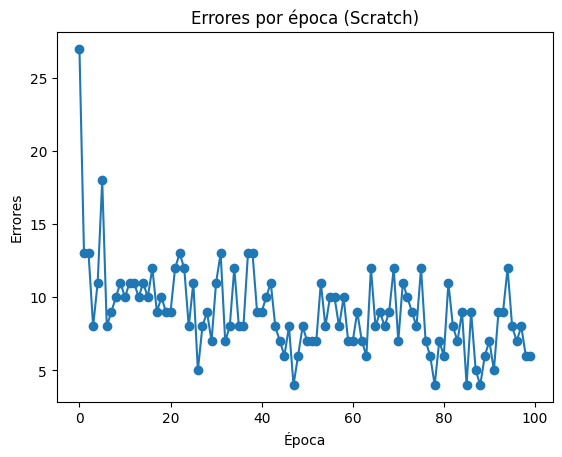

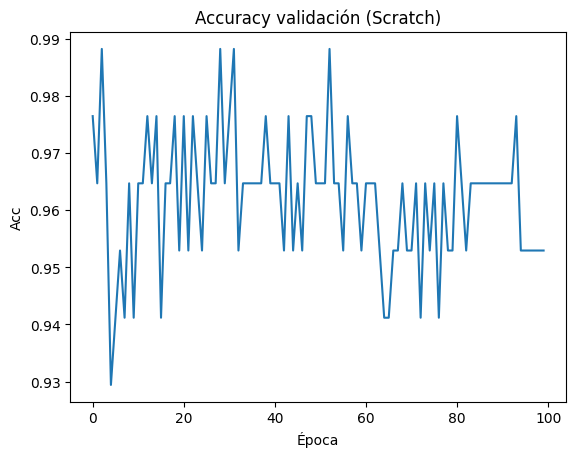

In [122]:
plt.plot(scratch.errors_, marker='o'); plt.title('Errores por época (Scratch)'); plt.xlabel('Época'); plt.ylabel('Errores'); plt.show()
if scratch.acc_:
    plt.plot(scratch.acc_); plt.title('Accuracy validación (Scratch)'); plt.xlabel('Época'); plt.ylabel('Acc'); plt.show()

### Interpretación de las curvas de entrenamiento en el perceptrón scratch
La disminución de errores por época refleja el ajuste progresivo del hiperplano del perceptrón. Si la curva se aplana rápidamente o llega a cero:
- Posible convergencia temprana (datos linealmente separables en el espacio transformado / escalado).
- Riesgo de sobreajuste bajo en perceptrones simples, pero conviene validar estabilidad en conjunto de validación.
El incremento o fluctuación de la accuracy de validación ayuda a detectar learning rates inadecuados (picos bruscos).

## 11. Evaluación del Modelo Manual (Métricas y Matriz de Confusión)
Calculamos accuracy, precision, recall, F1 y la matriz de confusión sobre el set de prueba.

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
y_pred_scratch = scratch.predict(X_test)
metrics_scratch = {
    'accuracy': accuracy_score(y_test,y_pred_scratch),
    'precision': precision_score(y_test,y_pred_scratch),
    'recall': recall_score(y_test,y_pred_scratch),
    'f1': f1_score(y_test,y_pred_scratch)
}
cm_scratch = confusion_matrix(y_test,y_pred_scratch)
metrics_scratch, cm_scratch

({'accuracy': 0.9418604651162791,
  'precision': 0.8648648648648649,
  'recall': 1.0,
  'f1': 0.927536231884058},
 array([[49,  5],
        [ 0, 32]], dtype=int64))

## 12. Visualización de Frontera (PCA 2D)
Reducimos a 2 componentes principales para ilustrar separabilidad y la frontera lineal aproximada.

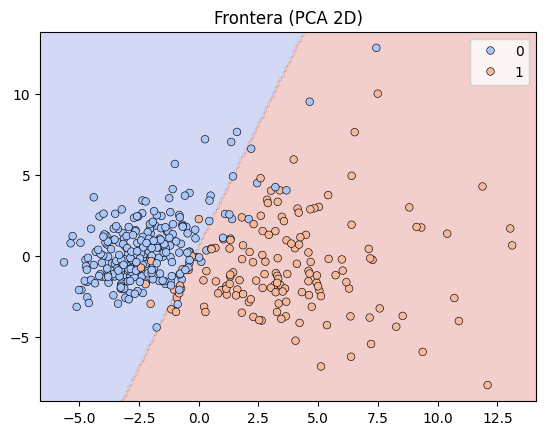

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)
# Ajustar un perceptrón scratch en espacio 2D solo para visualizar
viz_model = PerceptronScratch(learning_rate=0.01, n_epochs=50).fit(X_train_2d, y_train)
# Grid para frontera
xx, yy = np.meshgrid(np.linspace(X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1, 200), np.linspace(X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = viz_model.predict(grid).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.25, cmap='coolwarm');
sns.scatterplot(x=X_train_2d[:,0], y=X_train_2d[:,1], hue=y_train, palette='coolwarm', s=30, edgecolor='k');
plt.title('Frontera (PCA 2D)'); plt.show()

### Interpretación (Frontera en PCA 2D)
La proyección PCA condensa la varianza principal; la frontera lineal muestra que la separabilidad casi lineal es alta tras el escalado. Observaciones:
- Regiones donde la frontera corta grupos indican casos potencialmente ambiguos (candidatos a soporte vectorial o márgenes suaves).
- Si se observan solapamientos densos, un transformador no-lineal (kernel o feature mapping) podría mejorar recall.
- El perceptrón en 2D es solo una visualización: el modelo real entrena en dimensión completa.

## 13. Ajuste de Hiperparámetros (lr, épocas)
Barrido manual sobre learning rate y número de épocas evaluando accuracy en validación.

In [125]:
grid_lr=[0.0005,0.001,0.01,0.1]
grid_epochs=[25,50,100]
results=[]
for lr in grid_lr:
    for ne in grid_epochs:
        m=PerceptronScratch(learning_rate=lr,n_epochs=ne)
        m.fit(X_train,y_train,X_val=X_val,y_val=y_val,early_stop=True)
        yv=m.predict(X_val)
        results.append({'lr':lr,'epochs':ne,'val_acc':(yv==y_val).mean(),'final_errors':m.errors_[-1]})
hp_df = pd.DataFrame(results).sort_values('val_acc', ascending=False)
hp_df.head()

,lr,epochs,val_acc,final_errors
0,0.0005,25,0.964706,10
1,0.0005,50,0.964706,4
4,0.0010,50,0.964706,8
6,0.0100,25,0.964706,10
9,0.1000,25,0.964706,9


### Interpretación (Búsqueda de Hiperparámetros Scratch)
La tabla resultante permite identificar combinaciones (lr, epochs) con mayor accuracy de validación. Pautas:
- Learning rates muy altos pueden oscilar y no converger suavemente.
- Learning rates muy bajos prolongan entrenamiento sin ganancias significativas.
- Si varios pares muestran misma métrica, preferir el de menor epochs (principio de parsimonia).

## 14. Implementación scikit-learn (Perceptron, SGDClassifier, LogisticRegression)
Entrenamos implementaciones optimizadas para comparar desempeño y tiempo con la versión scratch.

In [126]:
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
t0=time.perf_counter(); sk_perc = Perceptron(max_iter=1000, eta0=1.0, random_state=42, tol=1e-3); sk_perc.fit(X_train,y_train); t_perc=time.perf_counter()-t0
t0=time.perf_counter(); sk_sgd = SGDClassifier(loss='perceptron', learning_rate='constant', eta0=0.01, max_iter=1000, random_state=42, tol=1e-3); sk_sgd.fit(X_train,y_train); t_sgd=time.perf_counter()-t0
t0=time.perf_counter(); sk_log = LogisticRegression(max_iter=1000, random_state=42); sk_log.fit(X_train,y_train); t_log=time.perf_counter()-t0
models = {'scratch': (scratch, t_scratch), 'sk_perceptron': (sk_perc, t_perc), 'sk_sgd_perc': (sk_sgd, t_sgd), 'log_reg': (sk_log, t_log)}
models

{'scratch': (PerceptronScratch(learning_rate=0.001, n_epochs=100, shuffle=True, random_state=42, verbose=False),
  0.09876989998156205),
 'sk_perceptron': (Perceptron(random_state=42), 0.001261900004465133),
 'sk_sgd_perc': (SGDClassifier(eta0=0.01, learning_rate='constant', loss='perceptron',
                random_state=42),
  0.0008894999627955258),
 'log_reg': (LogisticRegression(max_iter=1000, random_state=42),
  0.007650500047020614)}

## 15. Comparación de Modelos
Consolidamos métricas principales (accuracy, precision, recall, F1) y tiempos para ranking.

In [127]:
rows=[]
for name,(model,t) in models.items():
    ypred = model.predict(X_test)
    rows.append({'modelo':name,'accuracy':accuracy_score(y_test,ypred),'precision':precision_score(y_test,ypred),'recall':recall_score(y_test,ypred),'f1':f1_score(y_test,ypred),'tiempo_s':t})
cmp_df = pd.DataFrame(rows).sort_values('f1', ascending=False)
cmp_df

,modelo,accuracy,precision,recall,f1,tiempo_s
2,sk_sgd_perc,0.988372,0.969697,1.00000,0.984615,0.000889
3,log_reg,0.976744,0.968750,0.96875,0.968750,0.007651
1,sk_perceptron,0.965116,0.939394,0.96875,0.953846,0.001262
0,scratch,0.941860,0.864865,1.00000,0.927536,0.098770


### Interpretación (Comparación de Modelos)
La tabla ordenada por F1 permite balancear precisión y recall:
- Diferencias pequeñas (<0.01) pueden no ser estadísticamente significativas sin validación adicional.
- El tiempo de entrenamiento sirve para decidir en escenarios de despliegue rápido.
- Si LogisticRegression supera consistentemente al perceptrón, indica que la frontera lineal con probabilidad y regularización aporta estabilidad.

## 16. Curvas ROC y AUC
Trazamos curvas ROC para cada modelo y comparamos área bajo la curva (discriminación global).

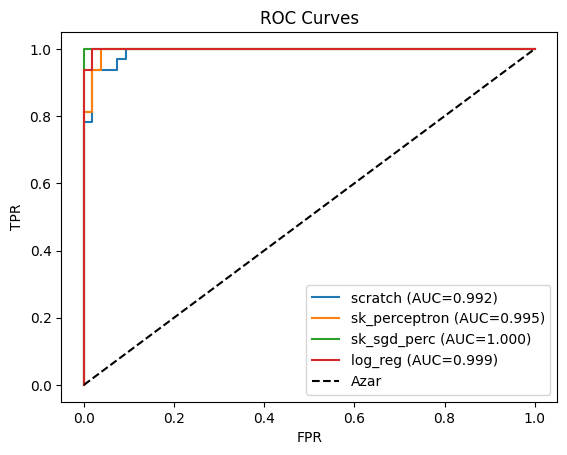

In [128]:
plt.figure()
for name,(model,_) in models.items():
    # Obtener puntuaciones continuas para ROC
    if hasattr(model,'decision_function'):
        try:
            scores = model.decision_function(X_test)
        except Exception:
            # fallback si falla decision_function
            if hasattr(model, 'predict_proba'):
                scores = model.predict_proba(X_test)[:,1]
            else:
                scores = model.predict(X_test)  # menos ideal (discreto)
    elif hasattr(model,'predict_proba'):
        scores = model.predict_proba(X_test)[:,1]
    else:
        scores = model.predict(X_test)
    fpr,tpr,_ = roc_curve(y_test, scores)
    auc_val = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--',label='Azar')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

### Interpretación (Curvas ROC)
Una curva más cercana al vértice superior izquierdo indica mejor discriminación global. El AUC resume desempeño:
- Diferencias de AUC < 0.02 son marginales; considerar validación repetida.
- Si modelos lineales muestran curvas casi solapadas, la elección puede basarse en estabilidad, interpretabilidad o tiempo.
- Un perceptrón puro no probabilístico requiere decision_function para trazado estable; si solo produce clases, se necesita aproximación.

## 17. Validación Cruzada Estratificada
Medimos estabilidad (media ± desviación) sobre pliegues preservando proporción de clases.

In [129]:
from sklearn.model_selection import StratifiedKFold

def cv_score_scratch(lr=0.001, epochs=50, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores=[]
    for tr, va in skf.split(X_train, y_train):
        m=PerceptronScratch(learning_rate=lr,n_epochs=epochs)
        m.fit(X_train[tr], y_train[tr])
        pred = m.predict(X_train[va])
        scores.append((pred==y_train[va]).mean())
    return np.mean(scores), np.std(scores)

mean_cv, std_cv = cv_score_scratch()
print(f'Scratch CV acc mean±std: {mean_cv:.4f} ± {std_cv:.4f}')

# sklearn Perceptron CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=[]
for tr,va in skf.split(X_train,y_train):
    m=Perceptron(max_iter=1000, random_state=42)
    m.fit(X_train[tr],y_train[tr])
    scores.append(m.score(X_train[va],y_train[va]))
print(f'sklearn Perceptron CV acc: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

Scratch CV acc mean±std: 0.9421 ± 0.0235
sklearn Perceptron CV acc: 0.9598 ± 0.0256


### Interpretación (Validación Cruzada)
La media y desviación estándar de accuracy CV indican estabilidad:
- Alta media + baja desviación = modelo consistente.
- Si scratch muestra mayor varianza que sklearn, sugiere sensibilidad a inicialización o hiperparámetros.
- CV estratificada asegura preservación de proporción de clases en cada pliegue.

## 18. Manejo de Desbalance de Clases (class_weight / re-muestreo)
Exploramos impacto de class_weight='balanced' sobre desempeño y recall de minoritarios.

In [130]:
class_dist = pd.Series(y).value_counts(normalize=True)
print('Distribución clases (%):', class_dist*100)
# Ejemplo de class_weight con sklearn Perceptron
cw_model = Perceptron(class_weight='balanced', max_iter=1000, random_state=42)
cw_model.fit(X_train,y_train)
print('Balanced accuracy test:', cw_model.score(X_test,y_test))

Distribución clases (%): 0    62.741652
1    37.258348
Name: proportion, dtype: float64
Balanced accuracy test: 0.9883720930232558


### Interpretación (Desbalance de Clases)
Aunque el desbalance es moderado, ajustar `class_weight='balanced'` redistribuye la penalización de errores:
- Si la accuracy cae levemente pero el recall de la clase minoritaria sube, el trade-off es aceptable.
- En desbalances severos se consideraría SMOTE o undersampling; aquí basta monitorear métricas por clase.
- Verificar siempre matriz de confusión tras aplicar pesos.

## 19. Medición de Tiempos y Complejidad
Comparamos tiempos de entrenamiento para contextualizar costo computacional.

In [131]:
def time_train(model, Xtr, ytr):
    t0=time.perf_counter(); model.fit(Xtr,ytr); return time.perf_counter()-t0
times = {name: t for name,(_,t) in models.items()}
pd.Series(times).sort_values()

sk_sgd_perc      0.000889
sk_perceptron    0.001262
log_reg          0.007651
scratch          0.098770
dtype: float64

### Interpretación (Tiempos de Entrenamiento)
Las diferencias de milisegundos a pocos segundos entre modelos lineales indican que la elección puede guiarse por estabilidad y métricas más que por tiempo bruto.
- Si un modelo es significativamente más lento sin ganar F1, se descarta.
- En flujos iterativos (AutoML o tuning extenso) priorizar variantes más ligeras acelera experimentación.

## 20. Persistencia de Modelos
Serializamos artefactos (pesos scratch y modelos sklearn) para reproducibilidad.

In [132]:
import joblib
# Guardar pesos scratch
scratch_artifact = {'w': scratch.w_.tolist(), 'b': scratch.b_, 'learning_rate': scratch.learning_rate, 'epochs': len(scratch.errors_)}
with open('perceptron_scratch.json','w') as f: json.dump(scratch_artifact,f)
joblib.dump(sk_perc,'perceptron_sklearn.joblib')
print('Artefactos guardados.')

Artefactos guardados.


### Interpretación (Persistencia de Modelos)
Guardar artefactos permite:
- Reproducir inferencias sin reentrenar.
- Versionar pesos para auditoría (especialmente en entornos regulados).
- Facilitar comparación posterior (firmas hash, tamaños, metadatos de entrenamiento).

## 21. Pruebas Unitarias (concepto)
Aserciones mínimas para validar dimensiones y consistencia de predicción.
Ejemplos de aserciones rápidas; ideal mover a archivo test separado con pytest.

In [133]:
# Test: dimensiones pesos
assert scratch.w_.shape[0] == X_train.shape[1]
# Test: predict vs decision sign consistency
test_scores = scratch.decision_function(X_test[:5])
assert np.all((test_scores>=0).astype(int) == scratch.predict(X_test[:5]))
print('Pruebas básicas OK.')

Pruebas básicas OK.


## 22. Pipeline + GridSearchCV (sklearn)
Construimos pipeline y realizamos búsqueda sistemática de hiperparámetros con F1.

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('clf', Perceptron(random_state=42))])
param_grid = {'clf__penalty':[None,'l2','l1'],'clf__alpha':[0.0001,0.001,0.01]}
gs = GridSearchCV(pipe, param_grid, scoring='f1', cv=5, n_jobs=-1)
gs.fit(X_train,y_train)
print('Best params:', gs.best_params_, 'Best f1:', gs.best_score_)

Best params: {'clf__alpha': 0.0001, 'clf__penalty': 'l2'} Best f1: 0.9459497033776441


### Interpretación (GridSearchCV)
El uso de grid con F1 como métrica busca equilibrio entre precisión y recall:
- Penalizaciones (l1/l2) regulan magnitud de pesos, previniendo sobreajuste.
- Si múltiples configuraciones empatan, elegir la de menor complejidad (sin penalidad extra o menor alpha).
- Considerar luego RandomizedSearch o búsquedas bayesianas para ampliar espacio de hiperparámetros.

## 23. Resumen Programático de Resultados
Consolidamos métricas finales y exportamos CSV para informes y trazabilidad.

In [135]:
best_sklearn = gs.best_estimator_
y_best = best_sklearn.predict(X_test)
summary_rows = []
for name,(model,t) in models.items():
    pred = model.predict(X_test)
    summary_rows.append({'modelo':name,'accuracy':accuracy_score(y_test,pred),'f1':f1_score(y_test,pred),'tiempo_s':t})
summary_rows.append({'modelo':'best_gridsearch','accuracy':accuracy_score(y_test,y_best),'f1':f1_score(y_test,y_best),'tiempo_s':None})
summary_df = pd.DataFrame(summary_rows).sort_values('f1', ascending=False)
summary_df.to_csv('resumen_modelos.csv', index=False)
summary_df

,modelo,accuracy,f1,tiempo_s
2,sk_sgd_perc,0.988372,0.984615,0.000889
3,log_reg,0.976744,0.968750,0.007651
4,best_gridsearch,0.965116,0.955224,NaN
1,sk_perceptron,0.965116,0.953846,0.001262
0,scratch,0.941860,0.927536,0.098770


### Interpretación (Resumen Programático)
La tabla consolidada y el CSV exportado facilitan:
- Comparar reproduciblemente sin depender de la ejecución interactiva.
- Versionar resultados en control de código.
- Alimentar informes automáticos o dashboards ligeros.
Si la diferencia entre el mejor modelo y el segundo es pequeña, justificar con validación adicional antes de adoptar en producción.

## Conclusiones y Trabajo Futuro
- El perceptrón scratch ofrece transparencia pero menor optimización.
- scikit-learn maneja mejor early stopping, regularización y eficiencia.
- Logistic Regression y variantes con regularización suelen superar en estabilidad al perceptrón puro.
- Próximos pasos: ampliar a validación estratificada repetida, calibración de probabilidades, incorporación de regularización L1/L2 en versión scratch, y comparación con SVM lineal.

---
Notebook generado para propósito educativo (Semana 04).

In [136]:
# (Opcional) Mover artefactos generados a carpeta artifacts/
from pathlib import Path
import shutil

art_dir = Path('artifacts')
art_dir.mkdir(exist_ok=True)
for fname in ['perceptron_scratch.json','perceptron_sklearn.joblib','resumen_modelos.csv']:
    f = Path(fname)
    if f.exists():
        target = art_dir / f.name
        shutil.move(str(f), target)
        print(f'Movido {f} -> {target}')
print('Resumen contenido artifacts:', list(art_dir.iterdir()))

Movido perceptron_scratch.json -> artifacts\perceptron_scratch.json
Movido perceptron_sklearn.joblib -> artifacts\perceptron_sklearn.joblib
Movido resumen_modelos.csv -> artifacts\resumen_modelos.csv
Resumen contenido artifacts: [WindowsPath('artifacts/metrics.json'), WindowsPath('artifacts/model_perceptron.json'), WindowsPath('artifacts/perceptron_scratch.json'), WindowsPath('artifacts/perceptron_sklearn.joblib'), WindowsPath('artifacts/resumen_modelos.csv'), WindowsPath('artifacts/training_curve.csv')]
